# CSC420 Assignment 4 Implementation Task

In [1]:
import matplotlib.pyplot as plt
import scipy
import cv2
import numpy as np
import math
from scipy.special import softmax
from sklearn import preprocessing

In [2]:
def get_image(path, coloring=cv2.IMREAD_GRAYSCALE):
    raw_image = cv2.imread(path)
    rgb_image = cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB)

    # For resize
    scale_percent = 200 # percent of original size
    width = int(raw_image.shape[1] * scale_percent / 100)
    height = int(raw_image.shape[0] * scale_percent / 100)
    dim = (width, height)
    resized_image = cv2.resize(raw_image, dim, interpolation = None)

    grey_image = cv2.imread(path, coloring)
    # plt.imshow(raw_image, vmin=0, vmax=255)
    # plt.imshow
    return rgb_image, grey_image, resized_image

In [3]:
def label_points(image, points):
    plt.imshow(image, cmap='gray')
    plt.scatter(points[0], points[1], s=5, color='blue')
    plt.show()
    return None

In [18]:
def label_est_homography(image, points1, points2):
    plt.figure(figsize=(15,15))
    plt.subplot(1,2,1),plt.imshow(image, cmap='gray'), plt.scatter(points1[0], points1[1], marker='s', s=15, color='red')
    plt.subplot(1,2,2), plt.imshow(image, cmap='gray'), plt.scatter(points2[0], points2[1], marker='s', s=15, color='green')
    plt.show()
    return None

In [5]:
def find_matrix(pairs=5, p1=None, p2=None):
    A = np.zeros(shape=(2 * pairs, 9), dtype=float)
    for i in range(pairs):
        # For odd rows 
        odd =2*i
        A[odd][0], A[odd][1] = p1[0][i], p1[1][i] # x_1, y_1
        A[odd][2] = 1 # 1
        A[odd][6] = - p2[0][i] *  p1[0][i] # - x_1' * x_1
        A[odd][7] = -  p2[0][i] * p1[1][i] # - x_1' * y_1
        A[odd][8] = -  p2[0][i] # - x_1'

        # For even rows 
        even = odd + 1
        A[even][3], A[even][4] = p1[0][i], p1[1][i] # x_1, y_1
        A[even][5] = 1 # 1
        A[even][6] = - p2[1][i] *  p1[0][i] # - y_1' * x_1
        A[even][7] = -  p2[1][i] * p1[1][i] # - y_1' * y_1
        A[even][8] = -  p2[1][i] # - y_1'
    return A

In [6]:
def compute_homography(A):
    B = np.matmul(A.T, A)
    eig_val, eig_vec = np.linalg.eig(B)
    min_index = np.where(eig_val == np.min(eig_val))[0]
    h = eig_vec[:, min_index]
    mat = h.reshape(3, 3)
    return mat

In [15]:
def compute_transformation(no_pairs, M, source, actual): 
    estimated = []
    for i in range(no_pairs):
        src = np.array( [source[0][i], source[1][i], 1])
        est = np.matmul(M, src)
        est /= est[2]
        estimated.append(est[:2])
    estimated = np.array(estimated).transpose(1,0)
    return estimated, actual

(<AxesSubplot: >, <matplotlib.image.AxesImage at 0x11b034ac730>)

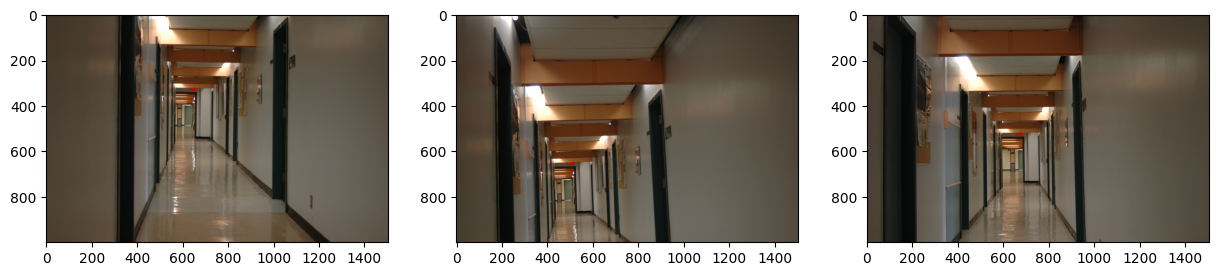

In [8]:
hallway_1, hallway_1_grey, hallway_1_resized = get_image('hallway_images/hallway1.jpg')
hallway_2, hallway_2_grey, hallway_2_resized = get_image('hallway_images/hallway2.jpg')
hallway_3, hallway_3_grey, hallway_3_resized = get_image('hallway_images/hallway3.jpg')
plt.figure(figsize=(15,15))
plt.subplot(1,3,1), plt.imshow(hallway_1)
plt.subplot(1,3,2), plt.imshow(hallway_2)
plt.subplot(1,3,3), plt.imshow(hallway_3)

In [9]:
# Hyperparameters
no_pairs = 5

## CASE I (right wall 1 ~ 2)

[850 942 843 946 994]
[254 268 642 392  75]


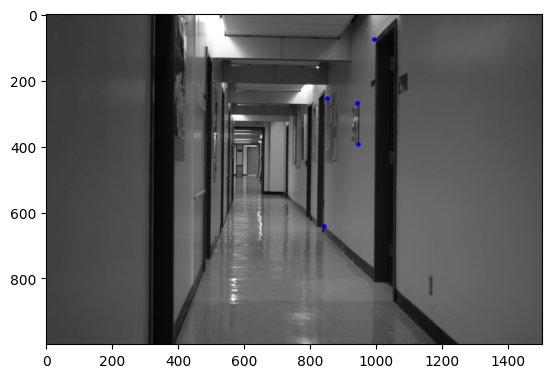

In [10]:
points_1_1 = [[850, 254], [942, 268], [843, 642], [946, 392], [994, 75]]
points_1_1 = np.array(points_1_1)
points_1_1= points_1_1.transpose((1, 0))
print(points_1_1[0])
print(points_1_1[1])
label_points(hallway_1_grey, points_1_1)

[708 721 805 812 840]
[576 958 575 704 395]


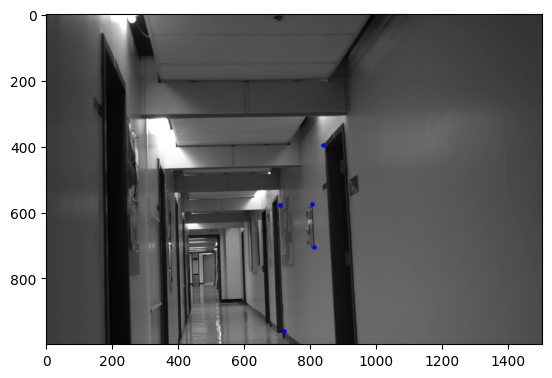

In [11]:
points_1_2 = [[708, 576], [721, 958], [805, 575], [812, 704], [840, 395]]
points_1_2 = np.array(points_1_2)
points_1_2= points_1_2.transpose((1, 0))
print(points_1_2[0])
print(points_1_2[1])
label_points(hallway_2_grey, points_1_2)

In [12]:
A = find_matrix(pairs=no_pairs, p1=points_1_1, p2=points_1_2)

In [13]:
M = compute_homography(A)
print(M)

[[-1.24638932e-03  1.29654860e-03  8.92992722e-01]
 [-6.37662507e-04  8.85906454e-04  4.50064233e-01]
 [-1.74762076e-06  1.53435821e-06  1.32610106e-03]]


[[707.11897483 728.9267301  805.17825472 809.83987856 840.24717355]
 [577.69093437 953.41883033 574.36235733 707.60665374 396.4402757 ]]
[[708 721 805 812 840]
 [576 958 575 704 395]]


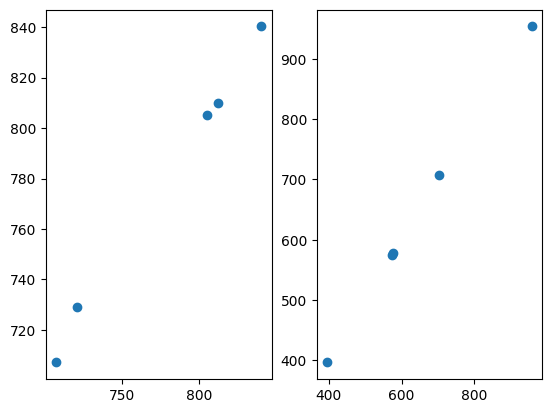

In [16]:
estimated, actual = compute_transformation(no_pairs=no_pairs, M=M, source=points_1_1, actual=points_1_2)
plt.subplot(1,2,1), plt.scatter(x=actual[0], y=estimated[0])
plt.subplot(1,2,2), plt.scatter(x=actual[1], y=estimated[1])
print(estimated)
print(actual)

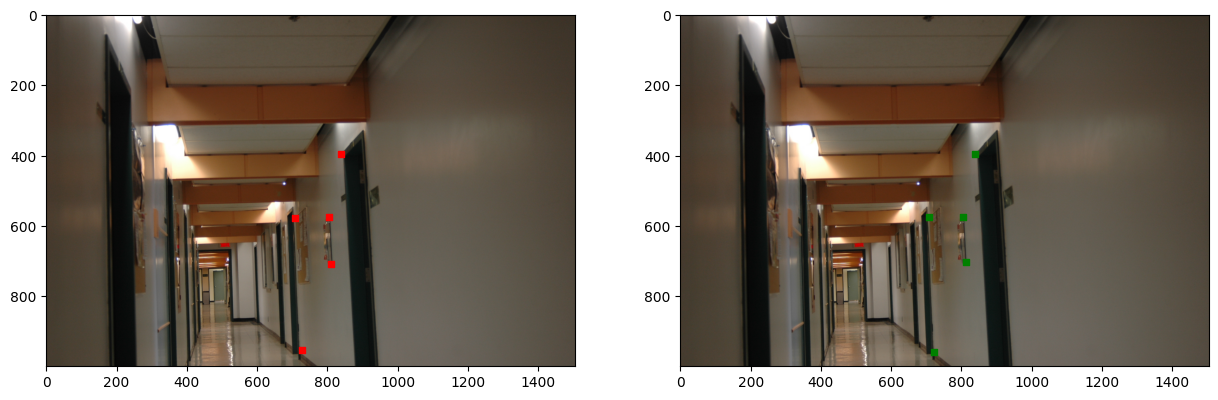

In [19]:
label_est_homography(hallway_2, estimated, actual)

## CASE 2: (right wall 1 ~ 3)

[850 942 843 946 994]
[254 268 642 392  75]


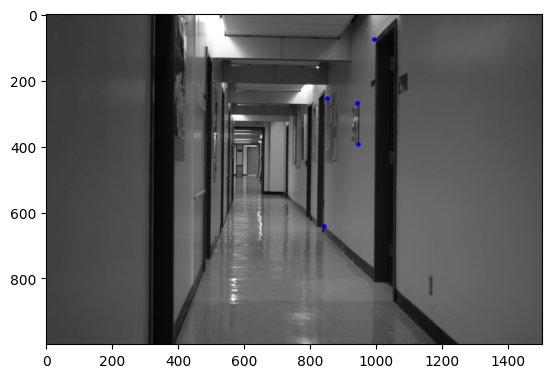

In [20]:
points_2_1 = [[850, 254], [942, 268], [843, 642], [946, 392], [994, 75]]
points_2_1 = np.array(points_2_1)
points_2_1= points_2_1.transpose((1, 0))
print(points_2_1[0])
print(points_2_1[1])
label_points(hallway_1_grey, points_2_1)

[850]
[254]


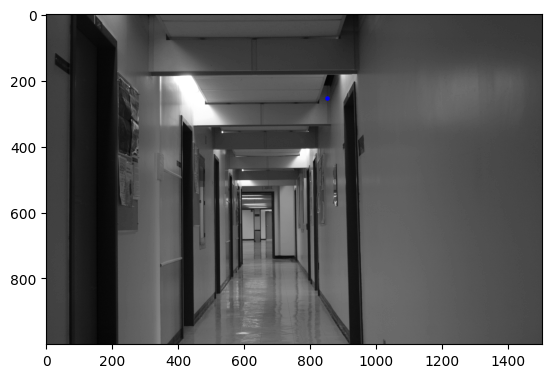

In [24]:
points_2_2 = [[850, 254]]
points_2_2 = np.array(points_2_2)
points_2_2= points_2_2.transpose((1, 0))
print(points_2_2[0])
print(points_2_2[1])
label_points(hallway_3_grey, points_2_2)